# Cars4U: Problem Statement
### Gelson J Pagan Diaz
#### Date: 12-17-2022
There is a huge demand for used cars in the Indian Market today. As sales of new cars have slowed down in the recent past,
 the pre-owned car market has continued to grow over the past years and is larger than the new car market now. Cars4U is a 
 budding tech start-up that aims to find footholes in this market.

In 2018-19, while new car sales were recorded at 3.6 million units, around 4 million second-hand cars were bought and sold.
There is a slowdown in new car sales and that could mean that the demand is shifting towards the pre-owned market. In fact,
 some car sellers replace their old cars with pre-owned cars instead of buying new ones. Unlike new cars, where price and supply are fairly deterministic and managed by OEMs (Original Equipment Manufacturer / except for dealership level discounts which come into play only in the last stage of the customer journey), used cars are very different beasts with huge uncertainty in both pricing and supply. Keeping this in mind, the pricing scheme of these used cars becomes important in order to grow in the market.

As a senior data scientist at Cars4U, you have to come up with a pricing model that can effectively predict the price of used cars and can help the business in devising profitable strategies using differential pricing. For example, if the business knows the market price, it will never sell anything below it.


## Objective
To explore and visualize the dataset, build a linear regression model to predict the prices of used cars, and generate a set of insights and recommendations that will help the business.


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

In [15]:
raw_data = pd.read_csv('used_cars_data.csv')
raw_data = raw_data.reset_index().drop(columns=['index'])
raw_data.head()

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,5.51,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,16.06,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,11.27,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,53.14,17.74


Lets first do the standard sanity data checks

In [16]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No.              7253 non-null   int64  
 1   Name               7253 non-null   object 
 2   Location           7253 non-null   object 
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7078 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          7253 non-null   float64
 13  Price              6019 non-null   float64
dtypes: float64(3), int64(3), object(8)
memory usage: 793.4+ KB


First of all, multiple variables (Mileage, Engine and Power) that ought to be numberic in nature are presented as objects. So let's fix that before anything else:

In [ ]:
# What are the units for Electric fuel type

In [100]:
# Given that mileage is given in kmpl which is dependent on the Fuel Type,
# we will keep that in mind
Fixing_Value = raw_data[['Fuel_Type','Mileage','Engine','Power']]

Fix_Vals_E = Fixing_Value['Engine'].str.split(" ", expand=True)
Fix_Vals_E.rename(columns={0:'Engine (CC)', 1:'Erase'}, inplace=True)
Fix_Vals_E['Engine (CC)'] = Fix_Vals_E['Engine (CC)'].astype('float')
Fix_Vals_P = Fixing_Value['Power'].str.split(" ", expand=True)
Fix_Vals_P.rename(columns={0:'Power (bhp)', 1:'Erase'}, inplace=True)
Fix_Vals_P['Power (bhp)'] = Fix_Vals_P['Power (bhp)'].astype('float')
Fix_Vals_M = Fixing_Value['Mileage'].str.split(" ", expand=True)
Fix_Vals_M.rename(columns={0:'Mileage', 1:'Mileage Unit'}, inplace=True)
Fix_Vals_M['Mileage'] = Fix_Vals_M['Mileage'].astype('float')
Fixing_Value = pd.concat([Fix_Vals_P.drop(columns=['Erase']),Fix_Vals_E.drop(columns=['Erase']),Fix_Vals_M,Fixing_Value['Fuel_Type']],axis=1,join='inner')

kmpl_conv = {'Petrol':0.79, 'Diesel':0.84, 'LPG':0.53} #Conversion of liter to kg for fuels reported in kmpl
# I checked the reported mileage for CNG and Electric fuel type to confirm that  it doesn't impede conversion
for k in kmpl_conv:
    Fixing_Value.loc[(Fixing_Value['Mileage Unit']=='kmpl')&(Fixing_Value['Fuel_Type']==k),['Mileage']]/=kmpl_conv[k]

Fixing_Value.rename(columns={'Mileage':'Mileage (km/kg)'}, inplace=True)
Fixing_Value = Fixing_Value.drop(columns=['Mileage Unit'])
Fixing_Value.head()

print(len(raw_data),len(Fixing_Value))


7253 7253


In [102]:
update_raw_data = pd.concat([raw_data.drop(columns=['Mileage','Engine','Power']).copy(),Fixing_Value[['Power (bhp)','Engine (CC)','Mileage (km/kg)']]],axis=1,join='inner')
update_raw_data['Make'] = update_raw_data['Name'].str.split(' ').str[0]
update_raw_data = update_raw_data.drop(columns = ['S.No.','Name'])
update_raw_data.head()


,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,Power (bhp),Engine (CC),Mileage (km/kg),Make
0,Mumbai,2010,72000,CNG,Manual,First,5.0,5.51,1.75,58.16,998.0,26.600000,Maruti
1,Pune,2015,41000,Diesel,Manual,First,5.0,16.06,12.50,126.20,1582.0,23.416667,Hyundai
2,Chennai,2011,46000,Petrol,Manual,First,5.0,8.61,4.50,88.70,1199.0,23.037975,Honda
3,Chennai,2012,87000,Diesel,Manual,First,7.0,11.27,6.00,88.76,1248.0,24.726190,Maruti
4,Coimbatore,2013,40670,Diesel,Automatic,Second,5.0,53.14,17.74,140.80,1968.0,18.095238,Audi


In [146]:
#Having a list of the variables to analize is always convenient, so doing this now
all_variables = update_raw_data.columns.values.tolist()
numerical_variables =  update_raw_data.select_dtypes([np.number]).columns.values.tolist()
categorical_variables = update_raw_data.select_dtypes(include='object').columns.values.tolist()

print('The numerical variables are: ',numerical_variables)
print('The categorical variables are:',categorical_variables)

The numerical variables are:  ['Year', 'Kilometers_Driven', 'Seats', 'New_Price', 'Price', 'Power (bhp)', 'Engine (CC)', 'Mileage (km/kg)']
The categorical variables are: ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Make']


So the data has been cleaned and organized and is ready to be analyzed. The units are now all consistent, the variables that were meant be numerical but were being interpreted as categorical due to the units were reformatted accordingly, and furthermore the 'Name' variable was parsed to create a new variable called Make (i.e. the car brand), since that should be considered as a likely candidate to effect the amount a consumer would pay for the car.

Moving on, there are various entries without their corresponding price. Given that we are developing a model to predict price, there is no use for entries without its price, therefore this entries should be altogether removed for the model formation.

They will be used later as a proof of concept.

In [240]:
final_test = update_raw_data[update_raw_data['Price'].isnull()].copy()
final_test

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,Power (bhp),Engine (CC),Mileage (km/kg),Make
6019,Delhi,2014,40929,CNG,Manual,First,4.0,4.360,NaN,58.20,998.0,32.260000,Maruti
6020,Coimbatore,2013,54493,Petrol,Manual,Second,5.0,4.360,NaN,47.30,796.0,31.265823,Maruti
6021,Mumbai,2017,34000,Diesel,Manual,First,7.0,25.270,NaN,147.80,2393.0,16.285714,Toyota
6022,Hyderabad,2012,139000,Diesel,Manual,First,5.0,8.525,NaN,NaN,1364.0,28.083333,Toyota
6023,Mumbai,2014,29000,Petrol,Manual,First,5.0,10.250,NaN,82.85,1197.0,23.417722,Hyundai
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7248,Hyderabad,2011,89411,Diesel,Manual,First,5.0,13.230,NaN,103.60,1598.0,24.452381,Volkswagen
7249,Mumbai,2015,59000,Petrol,Automatic,First,5.0,10.150,NaN,103.60,1197.0,21.784810,Volkswagen
7250,Kolkata,2012,28000,Diesel,Manual,First,5.0,9.470,NaN,63.10,1461.0,27.476190,Nissan
7251,Pune,2013,52262,Petrol,Automatic,Third,5.0,10.150,NaN,103.60,1197.0,21.772152,Volkswagen


In [155]:
modeling_data = update_raw_data.dropna(subset=['Price']).copy()
modeling_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6019 non-null   object 
 1   Year               6019 non-null   int64  
 2   Kilometers_Driven  6019 non-null   int64  
 3   Fuel_Type          6019 non-null   object 
 4   Transmission       6019 non-null   object 
 5   Owner_Type         6019 non-null   object 
 6   Seats              5977 non-null   float64
 7   New_Price          6019 non-null   float64
 8   Price              6019 non-null   float64
 9   Power (bhp)        5876 non-null   float64
 10  Engine (CC)        5983 non-null   float64
 11  Mileage (km/kg)    6017 non-null   float64
 12  Make               6019 non-null   object 
dtypes: float64(6), int64(2), object(5)
memory usage: 658.3+ KB


There seem to have been values that were null for Price that were also null for other values. (Initially thought that Price had the least values so there was descriptive values for every price value). Verifying:

In [106]:
Null_Price = update_raw_data.dropna(subset=['Price']).copy()
print(len(Null_Price[Null_Price.loc[:,['Mileage (km/kg)','Engine (CC)','Power (bhp)','Seats']].isnull().any(axis='columns')]))
Null_Price[Null_Price.loc[:,['Mileage (km/kg)','Engine (CC)','Power (bhp)','Seats']].isnull().any(axis='columns')]

147


,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,Power (bhp),Engine (CC),Mileage (km/kg),Make
76,Jaipur,2008,111111,Diesel,Manual,First,5.0,11.685,2.00,NaN,1399.0,21.190476,Ford
79,Hyderabad,2005,87591,Petrol,Manual,First,5.0,4.550,1.30,NaN,1086.0,0.000000,Hyundai
89,Hyderabad,2007,73745,Petrol,Manual,First,5.0,4.550,2.10,NaN,1086.0,21.518987,Hyundai
120,Mumbai,2005,102000,Petrol,Manual,Second,5.0,4.550,0.85,NaN,1086.0,21.518987,Hyundai
143,Kochi,2008,80759,Petrol,Manual,Third,5.0,4.550,1.67,NaN,1086.0,21.518987,Hyundai
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5873,Pune,2006,47200,Petrol,Manual,Second,5.0,4.550,1.20,NaN,1086.0,21.518987,Hyundai
5893,Chennai,2008,51000,Petrol,Manual,Second,NaN,7.880,1.75,NaN,1061.0,24.683544,Maruti
5925,Pune,2010,85000,Petrol,Manual,First,5.0,25.830,2.85,NaN,1798.0,22.151899,Skoda
5943,Chennai,2002,75000,Diesel,Manual,First,6.0,18.865,1.70,NaN,2112.0,0.000000,Mahindra


Confirmed that there are a total of 147 rows that contain null values in some combination of the variables of Mileage, Power, Seats and Engine. 

No need to remove this samples as of now. Special attention will be given when appropriate.

In [107]:
modeling_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,6019.0,2013.358199,3.269742,1998.00,2011.000000,2014.000000,2016.000000,2.019000e+03
Kilometers_Driven,6019.0,58738.380296,91268.843206,171.00,34000.000000,53000.000000,73000.000000,6.500000e+06
Seats,5977.0,5.278735,0.808840,0.00,5.000000,5.000000,5.000000,1.000000e+01
New_Price,6019.0,21.499855,24.332922,3.91,7.880000,11.300000,21.770000,3.750000e+02
Price,6019.0,9.479468,11.187917,0.44,3.500000,5.640000,9.950000,1.600000e+02
Power (bhp),5876.0,113.253050,53.874957,34.20,75.000000,97.700000,138.100000,5.600000e+02
Engine (CC),5983.0,1621.276450,601.355233,72.00,1198.000000,1493.000000,1984.000000,5.998000e+03
Mileage (km/kg),6017.0,22.136885,5.453250,0.00,18.734177,22.531646,25.822785,3.380952e+01


In [108]:
modeling_data.describe(include=[object]).T

,count,unique,top,freq
Location,6019,11,Mumbai,790
Fuel_Type,6019,5,Diesel,3205
Transmission,6019,2,Manual,4299
Owner_Type,6019,4,First,4929
Make,6019,31,Maruti,1211


We can see that most sample cars are a 5 seat cars that on average saw a reduction of price of ~50% after approximately 60k miles driven. Interestingly, this data is very different from US market, given that despite most cars pertaining to 2015 models (fairly recent), most of the data is of Manual and/or Diesel vehicles.

### Principal approach: 
After performing univariate analysis to determine spread, and determining outliers, pairwise scatter plots will be obtained to get a since of what general trends emerge. 
For combinations that useful correlation is observed, a regression model will be developed with 70% of a randomized selection of the modeling data, followed by a calculation of the quality of the fit. The remainder of the 30% will be used to test the fit for the pairwise combinations of relevant variables. With this information a general fit that includes all dependent variables will be generated in a hyper-plane fit, followed by a calculation of quality of fit, for the training and sequentially the test. Finally, a price recommendation will be offered for the sampled cars for which no price was provided.

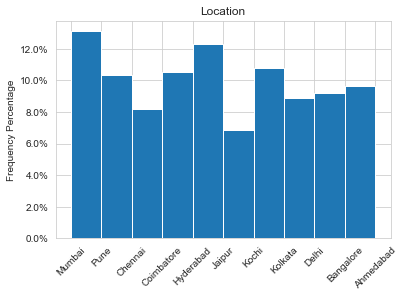

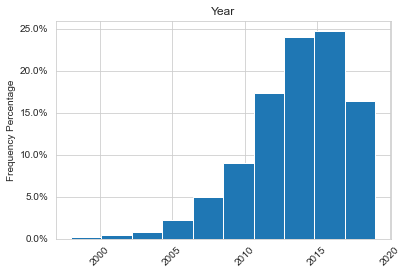

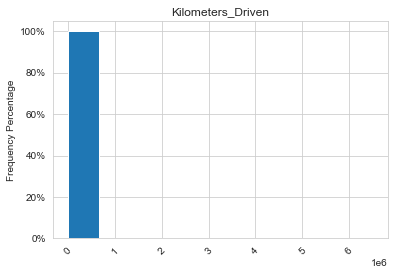

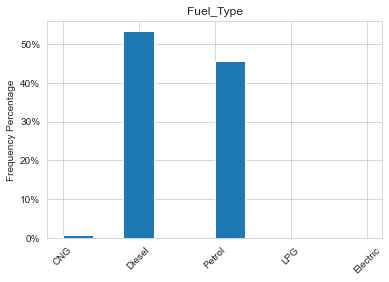

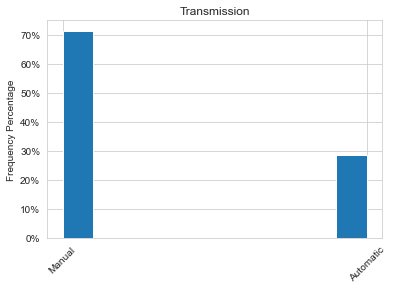

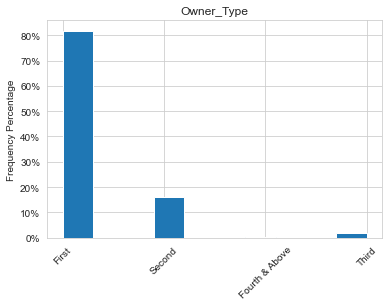

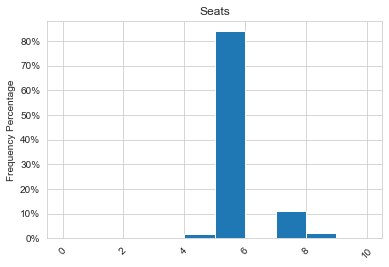

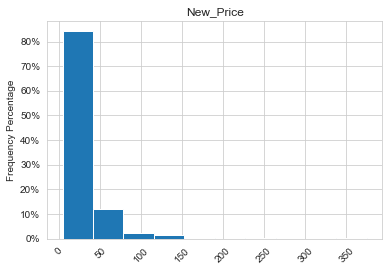

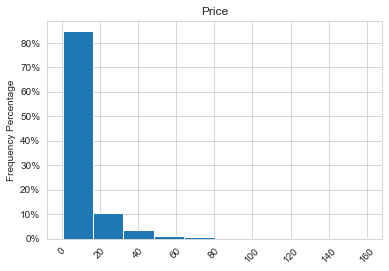

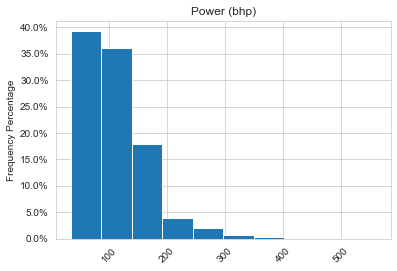

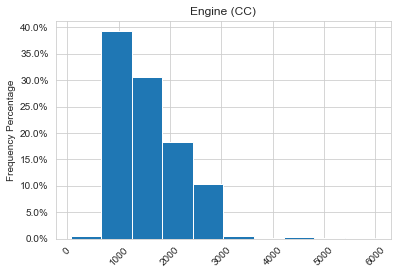

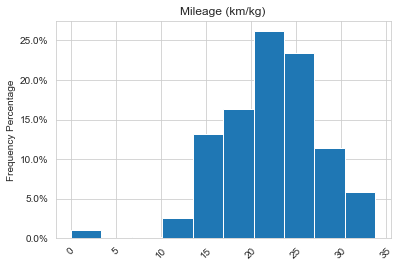

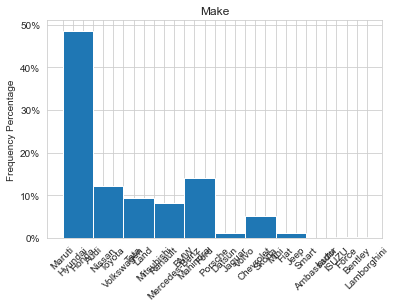

In [119]:
for x in all_variables:
    
    histo = modeling_data[str(x)].dropna()
    histo.hist(weights=np.ones(len(histo)) / len(histo))
    plt.title(x)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.ylabel('Frequency Percentage')
    plt.xticks(rotation = 45)
    plt.show()

The quantile values for 25, 50 and 75 percentiles respectively for  Year  are given by:
0.25    2011.0
0.50    2014.0
0.75    2016.0
Name: Year, dtype: float64
Resulting in an IQR of: 5.0
Leading to the respective lower and upper outer fences of 1996.0 and 2031.0


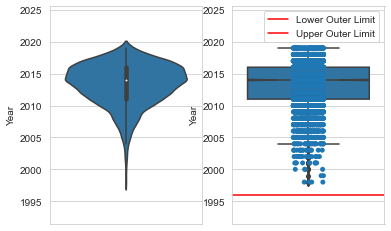

The quantile values for 25, 50 and 75 percentiles respectively for  Kilometers_Driven  are given by:
0.25    34000.0
0.50    53000.0
0.75    73000.0
Name: Kilometers_Driven, dtype: float64
Resulting in an IQR of: 39000.0
Leading to the respective lower and upper outer fences of -83000.0 and 190000.0


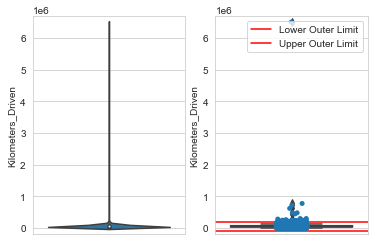

The quantile values for 25, 50 and 75 percentiles respectively for  Seats  are given by:
0.25    5.0
0.50    5.0
0.75    5.0
Name: Seats, dtype: float64
Resulting in an IQR of: 0.0
Leading to the respective lower and upper outer fences of 5.0 and 5.0


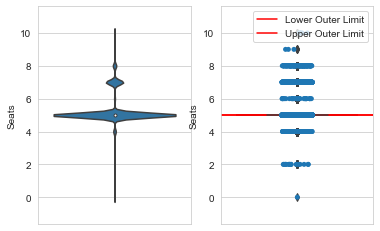

The quantile values for 25, 50 and 75 percentiles respectively for  New_Price  are given by:
0.25     7.88
0.50    11.30
0.75    21.77
Name: New_Price, dtype: float64
Resulting in an IQR of: 13.89
Leading to the respective lower and upper outer fences of -33.79 and 63.44


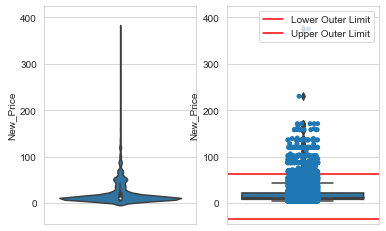

The quantile values for 25, 50 and 75 percentiles respectively for  Price  are given by:
0.25    3.50
0.50    5.64
0.75    9.95
Name: Price, dtype: float64
Resulting in an IQR of: 6.449999999999999
Leading to the respective lower and upper outer fences of -15.849999999999998 and 29.299999999999997


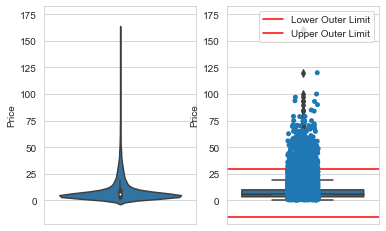

The quantile values for 25, 50 and 75 percentiles respectively for  Power (bhp)  are given by:
0.25     75.0
0.50     97.7
0.75    138.1
Name: Power (bhp), dtype: float64
Resulting in an IQR of: 63.099999999999994
Leading to the respective lower and upper outer fences of -114.29999999999998 and 327.4


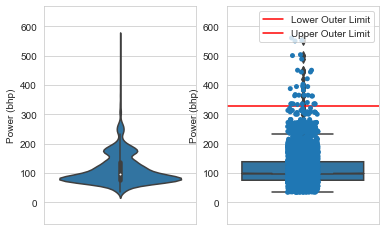

The quantile values for 25, 50 and 75 percentiles respectively for  Engine (CC)  are given by:
0.25    1198.0
0.50    1493.0
0.75    1984.0
Name: Engine (CC), dtype: float64
Resulting in an IQR of: 786.0
Leading to the respective lower and upper outer fences of -1160.0 and 4342.0


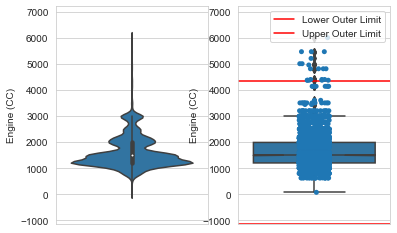

The quantile values for 25, 50 and 75 percentiles respectively for  Mileage (km/kg)  are given by:
0.25    18.734177
0.50    22.531646
0.75    25.822785
Name: Mileage (km/kg), dtype: float64
Resulting in an IQR of: 7.088607594936704
Leading to the respective lower and upper outer fences of -2.5316455696202382 and 47.08860759493669


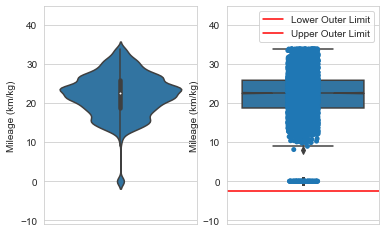

In [118]:
for n in numerical_variables:
    to_plot = modeling_data[n].dropna()
    quantile_data = to_plot.quantile([0.25,0.5,0.75])
    IQR = max(quantile_data.values)-min(quantile_data.values)
    low_out = min(quantile_data.values)-3*IQR
    upper_out = max(quantile_data.values)+3*IQR
    print('The quantile values for 25, 50 and 75 percentiles respectively for ',n,' are given by:')
    print(quantile_data)
    print('Resulting in an IQR of: '+str(IQR))
    print('Leading to the respective lower and upper outer fences of '+str(low_out)+' and '+str(upper_out))
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 2)
    _ylim = (min(to_plot.values)-2*np.std(to_plot.values),max(to_plot.values)+2*np.std(to_plot.values))
    plt.setp(axes, ylim=_ylim)
    sns.violinplot(y= to_plot,ax=axes[0])
    sns.boxplot(y = to_plot,notch=True,ax = axes[1])
    sns.stripplot(y = to_plot,ax=axes[1])
    plt.axhline(y = low_out, color = 'r', linestyle = '-',label='Lower Outer Limit')
    plt.axhline(y = upper_out, color = 'r', linestyle = '-',label='Upper Outer Limit')
    plt.legend(bbox_to_anchor = (1.0, 1),loc = 'upper right')
    
    plt.show()

There are multiple variables with outliers. However, for 5 out of the 6 such variables show outliers for data spread that seems very informative (e.g. price data spread matches new price data spread). The only variable with an outlier worth concern is Kilometers_Driven

In [121]:
data_kmoutlier = modeling_data['Kilometers_Driven'].dropna()
quantile_data = data_kmoutlier.quantile([0.25,0.5,0.75])
IQR = max(quantile_data.values)-min(quantile_data.values)
upper_out = max(quantile_data.values)+3*IQR

modeling_data[modeling_data['Kilometers_Driven']>upper_out]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,Power (bhp),Engine (CC),Mileage (km/kg),Make
29,Mumbai,2007,262000,Diesel,Manual,Fourth & Above,7.0,24.010,4.00,102.00,2494.0,15.238095,Toyota
77,Chennai,2006,230000,Petrol,Manual,Third,8.0,24.010,4.50,132.00,1998.0,15.696203,Toyota
181,Chennai,2006,216000,Diesel,Manual,Second,5.0,11.685,1.45,68.00,1399.0,21.190476,Ford
230,Jaipur,2007,200000,Diesel,Manual,Second,5.0,7.630,0.85,53.50,1396.0,20.476190,Tata
340,Kolkata,2013,775000,Diesel,Automatic,First,5.0,25.830,7.50,141.00,1968.0,22.976190,Skoda
358,Chennai,2009,620000,Petrol,Manual,First,5.0,10.250,2.70,78.90,1197.0,25.772152,Hyundai
576,Hyderabad,2012,202082,Diesel,Automatic,First,5.0,67.100,12.30,174.33,1968.0,21.047619,Audi
647,Jaipur,2004,200000,Petrol,Manual,First,5.0,4.550,0.80,NaN,1086.0,0.000000,Hyundai
792,Jaipur,2008,205000,Diesel,Manual,Second,7.0,35.290,3.90,141.00,2499.0,15.595238,Ford
838,Chennai,2016,215000,Diesel,Manual,First,7.0,11.670,7.50,118.30,2179.0,16.690476,Mahindra


We can see that the outlier belongs to a BMW Series 5 car from 2017 reporting 6.5 million km. This is extremely unrealistic! The most likely scenario for this value I hypothesize is that the data was entered with an extra zero accidentally. On the other hand, 650k is a realistic driven km for this model accroding to vehq.com. Therefore, I am switching this value to 650k from 6.5m.

In [156]:
modeling_data.loc[2328,'Kilometers_Driven'] = 650000
# modeling_data[modeling_data['Kilometers_Driven']>upper_out] 
# Was initially run just to confirm the change was done correctly

The quantile values for 25, 50 and 75 percentiles respectively for  Year  are given by:
0.25    2011.0
0.50    2014.0
0.75    2016.0
Name: Year, dtype: float64
Resulting in an IQR of: 5.0
Leading to the respective lower and upper outer fences of 1996.0 and 2031.0


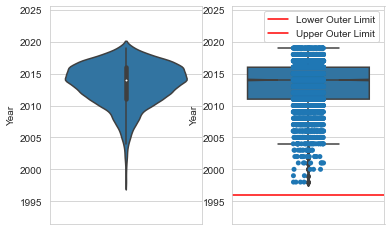

The quantile values for 25, 50 and 75 percentiles respectively for  Kilometers_Driven  are given by:
0.25    34000.0
0.50    53000.0
0.75    73000.0
Name: Kilometers_Driven, dtype: float64
Resulting in an IQR of: 39000.0
Leading to the respective lower and upper outer fences of -83000.0 and 190000.0


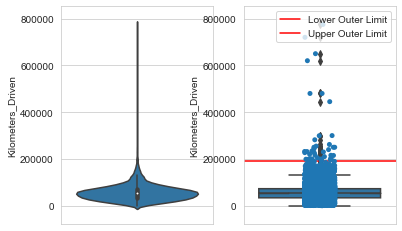

The quantile values for 25, 50 and 75 percentiles respectively for  Seats  are given by:
0.25    5.0
0.50    5.0
0.75    5.0
Name: Seats, dtype: float64
Resulting in an IQR of: 0.0
Leading to the respective lower and upper outer fences of 5.0 and 5.0


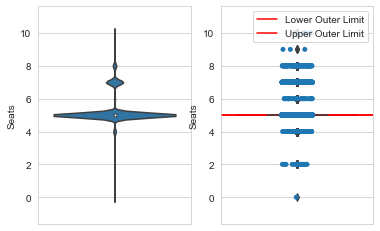

The quantile values for 25, 50 and 75 percentiles respectively for  New_Price  are given by:
0.25     7.88
0.50    11.30
0.75    21.77
Name: New_Price, dtype: float64
Resulting in an IQR of: 13.89
Leading to the respective lower and upper outer fences of -33.79 and 63.44


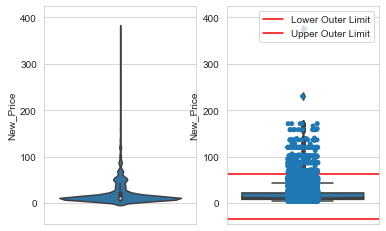

The quantile values for 25, 50 and 75 percentiles respectively for  Price  are given by:
0.25    3.50
0.50    5.64
0.75    9.95
Name: Price, dtype: float64
Resulting in an IQR of: 6.449999999999999
Leading to the respective lower and upper outer fences of -15.849999999999998 and 29.299999999999997


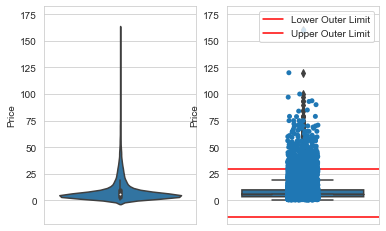

The quantile values for 25, 50 and 75 percentiles respectively for  Power (bhp)  are given by:
0.25     75.0
0.50     97.7
0.75    138.1
Name: Power (bhp), dtype: float64
Resulting in an IQR of: 63.099999999999994
Leading to the respective lower and upper outer fences of -114.29999999999998 and 327.4


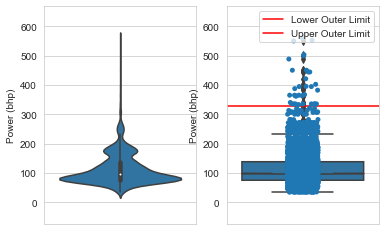

The quantile values for 25, 50 and 75 percentiles respectively for  Engine (CC)  are given by:
0.25    1198.0
0.50    1493.0
0.75    1984.0
Name: Engine (CC), dtype: float64
Resulting in an IQR of: 786.0
Leading to the respective lower and upper outer fences of -1160.0 and 4342.0


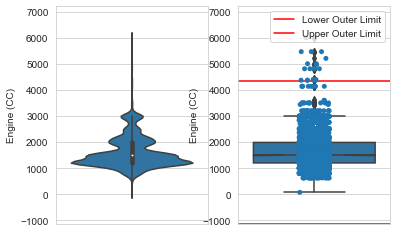

The quantile values for 25, 50 and 75 percentiles respectively for  Mileage (km/kg)  are given by:
0.25    18.734177
0.50    22.531646
0.75    25.822785
Name: Mileage (km/kg), dtype: float64
Resulting in an IQR of: 7.088607594936704
Leading to the respective lower and upper outer fences of -2.5316455696202382 and 47.08860759493669


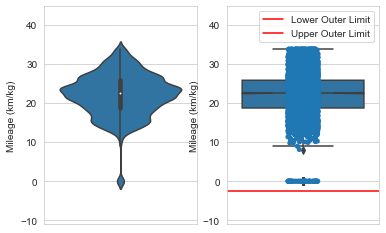

In [125]:
# Plotting for IQR again
for n in numerical_variables:
    to_plot = modeling_data[n].dropna()
    quantile_data = to_plot.quantile([0.25,0.5,0.75])
    IQR = max(quantile_data.values)-min(quantile_data.values)
    low_out = min(quantile_data.values)-3*IQR
    upper_out = max(quantile_data.values)+3*IQR
    print('The quantile values for 25, 50 and 75 percentiles respectively for ',n,' are given by:')
    print(quantile_data)
    print('Resulting in an IQR of: '+str(IQR))
    print('Leading to the respective lower and upper outer fences of '+str(low_out)+' and '+str(upper_out))
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 2)
    _ylim = (min(to_plot.values)-2*np.std(to_plot.values),max(to_plot.values)+2*np.std(to_plot.values))
    plt.setp(axes, ylim=_ylim)
    sns.violinplot(y= to_plot,ax=axes[0])
    sns.boxplot(y = to_plot,notch=True,ax = axes[1])
    sns.stripplot(y = to_plot,ax=axes[1])
    plt.axhline(y = low_out, color = 'r', linestyle = '-',label='Lower Outer Limit')
    plt.axhline(y = upper_out, color = 'r', linestyle = '-',label='Upper Outer Limit')
    plt.legend(bbox_to_anchor = (1.0, 1),loc = 'upper right')
    
    plt.show()

### Bivariate Analysis
A pairwise plotting will be done to get a general sense of what variables seem useful/correlated to prices.

For practical reasons, mean prices grouped by categorical values will be separated and plotted to qualitatively assess if prices seem to cluster for each categorical. 

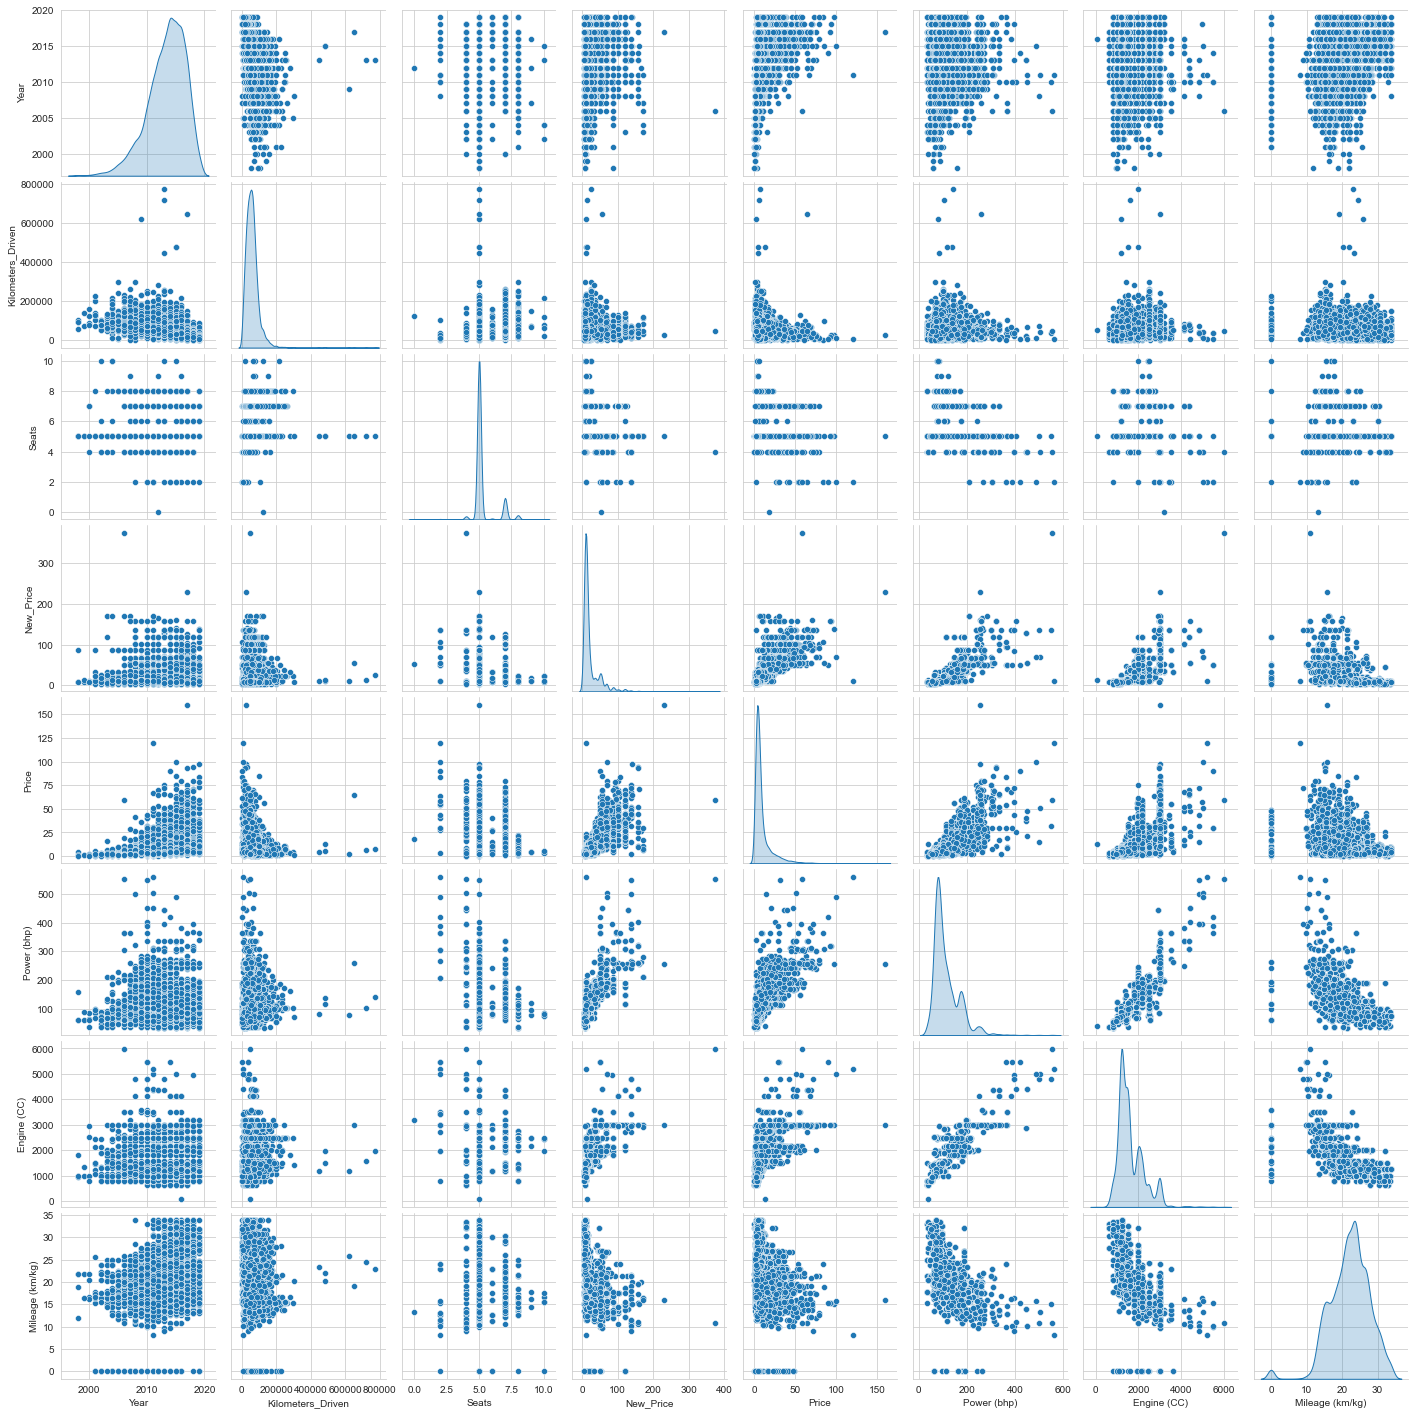

In [129]:
num_data_for_pairwise = modeling_data[numerical_variables].copy()
sns.pairplot(num_data_for_pairwise, diag_kind='kde')

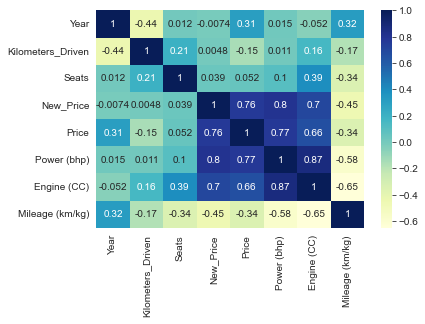

In [132]:

var_corr = sns.heatmap(modeling_data[numerical_variables].corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

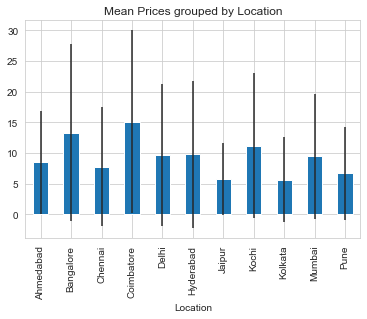

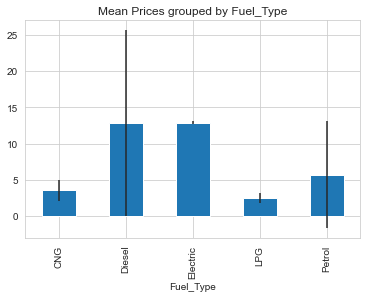

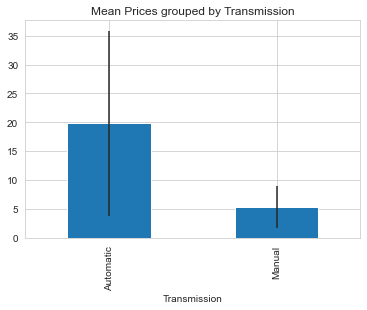

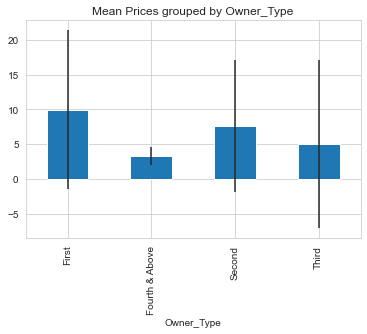

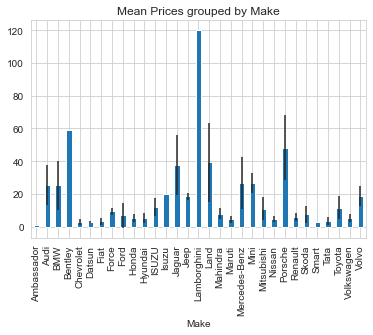

In [131]:

cat_data_for_pairwise = modeling_data[categorical_variables].copy()
for x in categorical_variables:
    to_plot = modeling_data.groupby(x).agg([np.mean,np.std])
    price = to_plot['Price']
    price.plot(kind = "bar", y = "mean", legend = False,
            title = "Mean Prices grouped by "+x, yerr = "std")
    plt.show()



0         Mumbai
1           Pune
2        Chennai
3     Coimbatore
4      Hyderabad
5         Jaipur
6          Kochi
7        Kolkata
8          Delhi
9      Bangalore
10     Ahmedabad
dtype: object


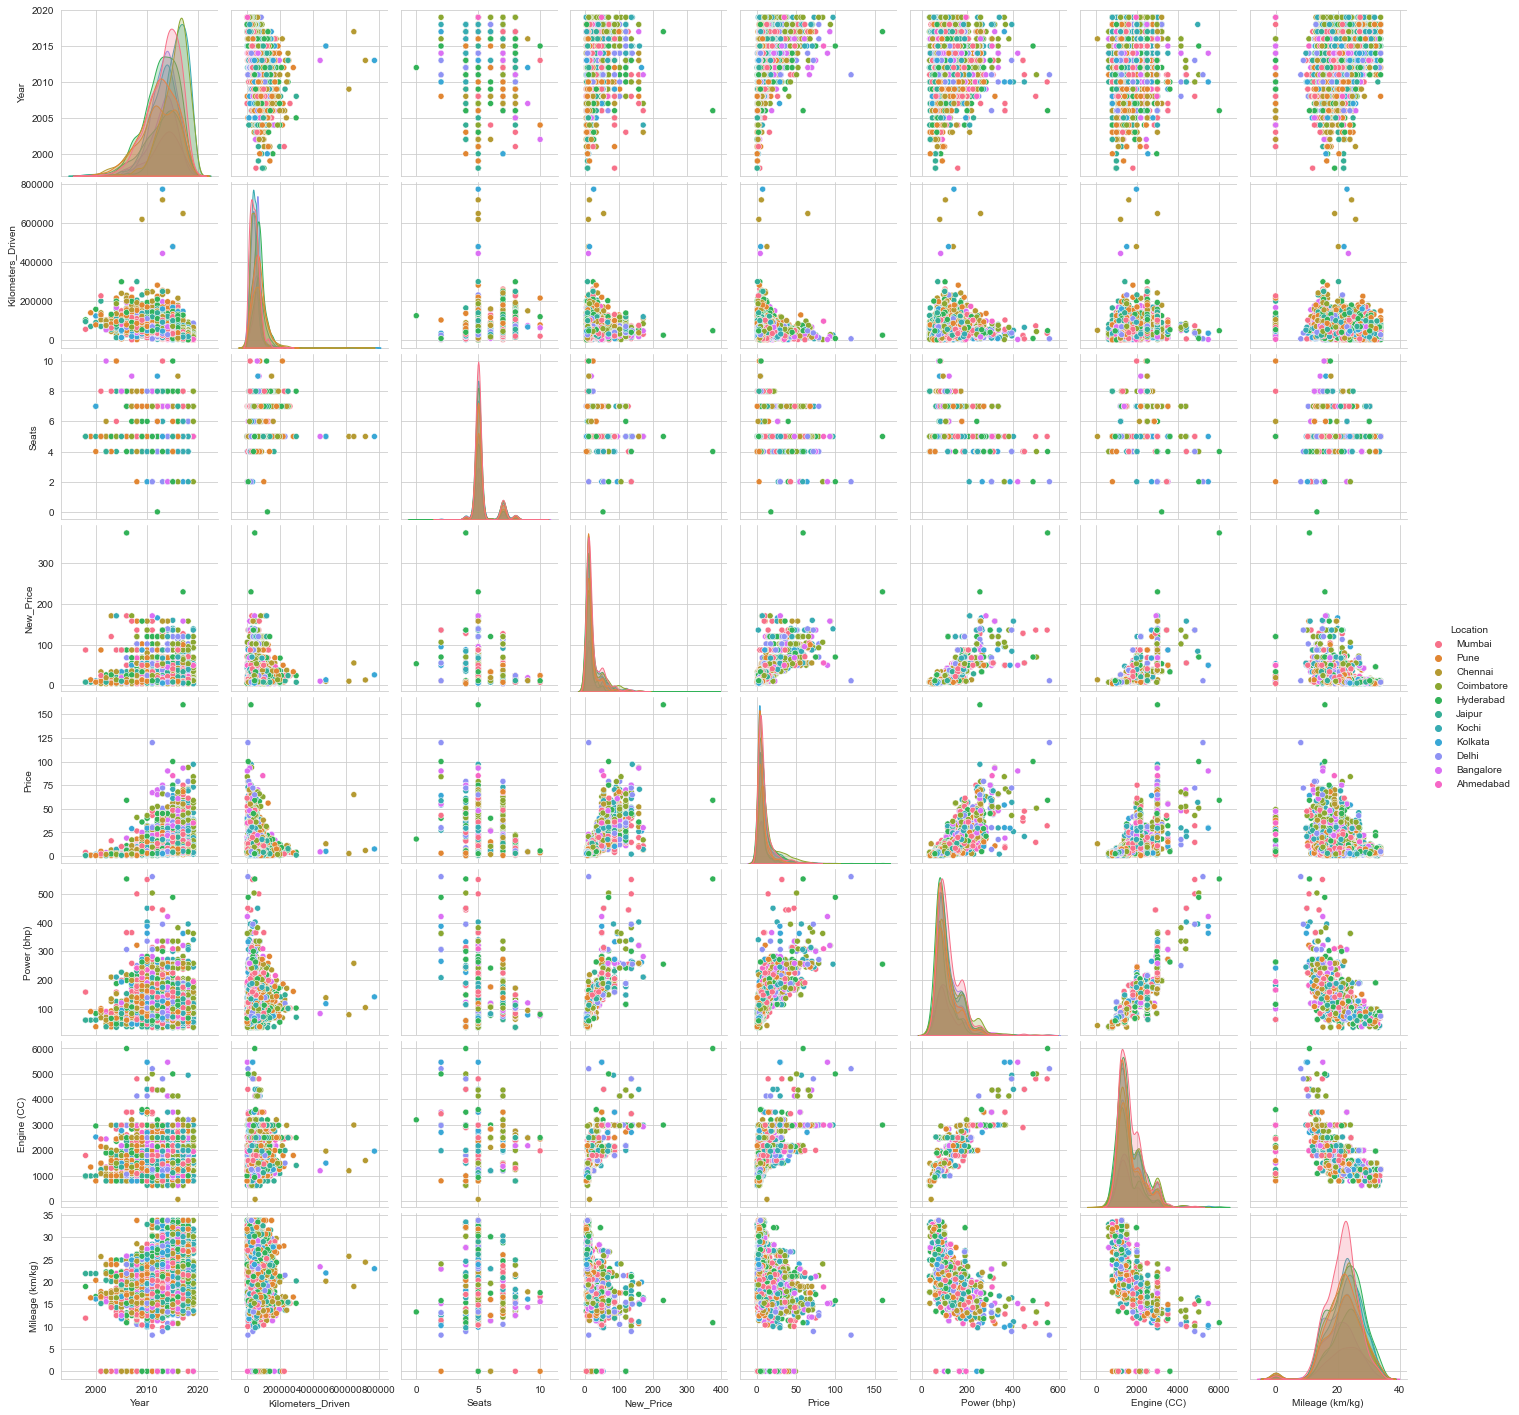

In [150]:
temp = numerical_variables.copy()
temp.append('Location')
temp_df = modeling_data[temp].copy()
index_map = temp_df['Location'].unique()
print(pd.Series(index_map))
indx = 0
for i in index_map:
    temp_df.loc[temp_df['Location']==i,x]=indx
    indx+=1
        
sns.pairplot(modeling_data[temp], hue="Location")


Looking at the pairwise scatter plots we can see that the prices are not particularly linear with respect to other variables but still showing some correlation not close to zero.

For this study, variables that show an absolute value of correlation of above 0.1 will be eligible to be included in the linear regression model.
These include:
- Mileage
- Engine
- Power
- Price of vehicle (new)
- Kilometers
- Year

Furthermore, categorical variables that show trends or statistically different means of price for each value will also be included in the model. Specifically, this disqualifies Location, as there was no apparent trend in the price for different locations.This observation can be further validated by the pairwise plots showing how grouping by different locations does not show any clustering but rather it following similar trends for different variables.

## Split Data

With a clear understanding of variables, the data will be split between dependent and independent variables.

Before that, dummy variables will be created for the categorical data, followed by a substitution of NaN values to the median of the variable.

In [151]:
print(categorical_variables)

['Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Make']


In [161]:
prep_data = pd.get_dummies(modeling_data.drop(columns=['Location']), columns=categorical_variables[1:])
print(prep_data.columns.values)

['Year' 'Kilometers_Driven' 'Seats' 'New_Price' 'Price' 'Power (bhp)'
 'Engine (CC)' 'Mileage (km/kg)' 'Fuel_Type_CNG' 'Fuel_Type_Diesel'
 'Fuel_Type_Electric' 'Fuel_Type_LPG' 'Fuel_Type_Petrol'
 'Transmission_Automatic' 'Transmission_Manual' 'Owner_Type_First'
 'Owner_Type_Fourth & Above' 'Owner_Type_Second' 'Owner_Type_Third'
 'Make_Ambassador' 'Make_Audi' 'Make_BMW' 'Make_Bentley' 'Make_Chevrolet'
 'Make_Datsun' 'Make_Fiat' 'Make_Force' 'Make_Ford' 'Make_Honda'
 'Make_Hyundai' 'Make_ISUZU' 'Make_Isuzu' 'Make_Jaguar' 'Make_Jeep'
 'Make_Lamborghini' 'Make_Land' 'Make_Mahindra' 'Make_Maruti'
 'Make_Mercedes-Benz' 'Make_Mini' 'Make_Mitsubishi' 'Make_Nissan'
 'Make_Porsche' 'Make_Renault' 'Make_Skoda' 'Make_Smart' 'Make_Tata'
 'Make_Toyota' 'Make_Volkswagen' 'Make_Volvo']


In [162]:
#Confirming that all our data is in numerical form for modeling
prep_data.dtypes

Year                           int64
Kilometers_Driven              int64
Seats                        float64
New_Price                    float64
Price                        float64
Power (bhp)                  float64
Engine (CC)                  float64
Mileage (km/kg)              float64
Fuel_Type_CNG                  uint8
Fuel_Type_Diesel               uint8
Fuel_Type_Electric             uint8
Fuel_Type_LPG                  uint8
Fuel_Type_Petrol               uint8
Transmission_Automatic         uint8
Transmission_Manual            uint8
Owner_Type_First               uint8
Owner_Type_Fourth & Above      uint8
Owner_Type_Second              uint8
Owner_Type_Third               uint8
Make_Ambassador                uint8
Make_Audi                      uint8
Make_BMW                       uint8
Make_Bentley                   uint8
Make_Chevrolet                 uint8
Make_Datsun                    uint8
Make_Fiat                      uint8
Make_Force                     uint8
M

In [163]:
# replace the missing values with median value
medianFiller = lambda x: x.fillna(x.median())
prepped_data = prep_data.apply(medianFiller,axis=0)


In [167]:
# Ready to train
# Let's import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 


In [166]:
X = prepped_data.drop(columns = ['Price'])
Y = prepped_data[['Price']]

In [181]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

## Fit linear model

In [182]:
regression_model = LinearRegression()
regression_model.fit(X_train, Y_train)

LinearRegression()

In [183]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for Year is 0.9639400319965278
The coefficient for Kilometers_Driven is -1.6395378764032367e-05
The coefficient for Seats is -0.21231657396714215
The coefficient for New_Price is 0.15735998579087665
The coefficient for Power (bhp) is 0.06849631477333969
The coefficient for Engine (CC) is 0.001164457269423519
The coefficient for Mileage (km/kg) is -0.08656984600049744
The coefficient for Fuel_Type_CNG is -2.5260673631312085
The coefficient for Fuel_Type_Diesel is -1.2118893687364278
The coefficient for Fuel_Type_Electric is 5.7084582977366205
The coefficient for Fuel_Type_LPG is 0.30672054409834504
The coefficient for Fuel_Type_Petrol is -2.277222109965709
The coefficient for Transmission_Automatic is -0.0946791456910443
The coefficient for Transmission_Manual is 0.0946791456909375
The coefficient for Owner_Type_First is -0.3789247702552636
The coefficient for Owner_Type_Fourth & Above is 0.7257320300888281
The coefficient for Owner_Type_Second is -0.6408114038971899
The

In [171]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -1936.5769170545916


In [184]:
regression_model.score(X_train, Y_train)

0.7687541190354599

In [186]:
#out of sample score (R^2)

regression_model.score(X_test, Y_test)

0.8021399344452296

With an in-sample score of 0.77 compared to an out of sample score of 0.8, we can feel fairly confident that the model is behaving fairly well as a predictor of car prices.

In [179]:
#adjusted R-squared
1 - (1-regression_model.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)

0.7764688897745351

Given the high amount of variables that I added to be able to include the make as a variable, using the adjusted R-squared value is extremely necessary at this point. Nevertheless, the adjusted R-squared shows that our model worked extremely well for a linear model, with a final value of 0.78.

Given that we are exclusively testing linear models for this goal, MSE and RMSE aren't necessarily too informative but still valid to observe for reference for future model development for this dataset:

In [187]:
Y_prediction = regression_model.predict(X)

In [190]:
from sklearn.metrics import mean_squared_error
import math
print('The Mean Squared Error is: ',mean_squared_error(Y, Y_prediction))
print('The Root Mean Squared Error is: ',math.sqrt(mean_squared_error(Y, Y_prediction)))

The Mean Squared Error is:  27.74685029997515
The Root Mean Squared Error is:  5.26752791164652


In [192]:
from sklearn.metrics import mean_absolute_error
print('The Mean Absolute Error is: ',mean_absolute_error(Y, Y_prediction))

The Mean Absolute Error is:  2.8996186237782706


While we don't have multiple models to compare performance, we can still compare the multiple performance metrics to assess that there are not large prediction errors. This conclusion comes from the fact that the mean absolute error is not extremely different from the mean square error which tends to penalize large prediction errors. 

Regardless, observing the increase between them would suggest the presence of some individual large prediction errors. 

Another visual way of validating the model is to simply plot the prices (Y values) with the predicted prices (Y_predicted):

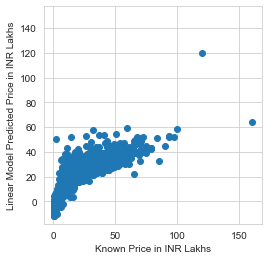

In [211]:
plt.scatter(Y.values,Y_prediction)
plt.xlabel('Known Price in INR Lakhs')
plt.ylabel('Linear Model Predicted Price in INR Lakhs')
plt.axis('square')
plt.show()

In [201]:
modeling_data.loc[Y[Y['Price']>150].index]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,Power (bhp),Engine (CC),Mileage (km/kg),Make
4079,Hyderabad,2017,25000,Diesel,Automatic,First,5.0,230.0,160.0,255.0,2993.0,15.869048,Land


Understanding of the model performance can be increased by observing the the above plot. A perfect model would be one which would give a perfect one-to-one relation between a known price value and the predicted value. It can be appreciated that while the resulting scatter plot doesn't show consistent large deviations (i.e. consistently >2x), we can see that the model shows a tendency to overestimate the price for costs lower that 20 INR Lakhs and slowly starts to underestimate for values above 20.

A very large prediction error is for a car that costs 160, yet our model would have predicted it to cost only around 60. At face value, it might be possible that the car may have been over priced. Yet when we observe the identity of this sample on the Dataframe we see that the car was a 2017 Land priced at 230 INR Lakhs when new. This 70 INR Lakhs decrease is not far from the median decrease between new and old cars. Therefore, more information would be usedful to further expand on the car pricing, despite the fact the model behaving fairly well.

In [280]:
# Formatting the Final Test data to run through 
final_prep_data = pd.get_dummies(final_test.drop(columns=['Location','Price']), columns=['Make','Owner_Type','Transmission','Fuel_Type'])
# replace the missing values with median value
medianFiller = lambda x: x.fillna(x.median())
final_prepped_data = final_prep_data.apply(medianFiller,axis=0)

#Final Test data contained samples for which there was not data to match to the model
#It is being formatted to be able to make suggestions to the main values for which a strong predictive model was developed.
df_copy = pd.DataFrame(columns = X.columns.values)
df_copy_2 = pd.concat([df_copy,final_prepped_data])
df_copy_3 = df_copy_2.drop(columns = ['Make_Hindustan','Make_OpelCorsa']).copy()
df_copy_3 = df_copy_3.fillna(0)

suggested_price = regression_model.predict(df_copy_3)
final_test['Price'] = suggested_price
display(final_test)

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,New_Price,Price,Power (bhp),Engine (CC),Mileage (km/kg),Make
6019,Delhi,2014,40929,CNG,Manual,First,4.0,4.360,2.578662,58.20,998.0,32.260000,Maruti
6020,Coimbatore,2013,54493,Petrol,Manual,Second,5.0,4.360,0.271213,47.30,796.0,31.265823,Maruti
6021,Mumbai,2017,34000,Diesel,Manual,First,7.0,25.270,18.097331,147.80,2393.0,16.285714,Toyota
6022,Hyderabad,2012,139000,Diesel,Manual,First,5.0,8.525,3.420561,NaN,1364.0,28.083333,Toyota
6023,Mumbai,2014,29000,Petrol,Manual,First,5.0,10.250,5.043823,82.85,1197.0,23.417722,Hyundai
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7248,Hyderabad,2011,89411,Diesel,Manual,First,5.0,13.230,3.761131,103.60,1598.0,24.452381,Volkswagen
7249,Mumbai,2015,59000,Petrol,Automatic,First,5.0,10.150,6.140115,103.60,1197.0,21.784810,Volkswagen
7250,Kolkata,2012,28000,Diesel,Manual,First,5.0,9.470,2.130131,63.10,1461.0,27.476190,Nissan
7251,Pune,2013,52262,Petrol,Automatic,Third,5.0,10.150,4.996732,103.60,1197.0,21.772152,Volkswagen


Above are the suggested prices for the cars for which no prices had been set for the seller to consider. Full list can be provided upon request.